# IMPORT THE REQUIRED LIBRARIES AND DATASET

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

In [2]:
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

In [3]:
import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [4]:
data = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [6]:
data.head(20)

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0   TCGA_CS_4941            2.0                 4.0             2        2.0   
1   TCGA_CS_4942            1.0                 5.0             2        1.0   
2   TCGA_CS_4943            1.0                 5.0             2        1.0   
3   TCGA_CS_4944            NaN                 5.0             2        1.0   
4   TCGA_CS_5393            4.0                 5.0             2        1.0   
5   TCGA_CS_5395            2.0                 4.0             2        2.0   
6   TCGA_CS_5396            3.0                 3.0             2        3.0   
7   TCGA_CS_5397            NaN                 4.0             1        2.0   
8   TCGA_CS_6186            2.0                 4.0             1        2.0   
9   TCGA_CS_6188            2.0                 4.0             3        2.0   
10  TCGA_CS_6290            1.0                 5.0             2        1.0   
11  TCGA_CS_6665            2.0                 5.0             1        1.0   
12  TCGA_CS_6666            NaN                 5.0             2        1.0   
13  TCGA_CS_6667            1.0                 3.0             1        1.0   
14  TCGA_CS_6668            3.0                 2.0             2        3.0   
15  TCGA_CS_6669            4.0                 1.0             1        1.0   
16  TCGA_DU_5849            4.0                 2.0             2        3.0   
17  TCGA_DU_5851            4.0                 5.0             1        1.0   
18  TCGA_DU_5852            2.0                 4.0             4        2.0   
19  TCGA_DU_5853            1.0                 5.0             2        1.0   

    RPPACluster  OncosignCluster  COCCluster  histological_type  \
0           NaN              3.0           2                1.0   
1           1.0              2.0           1                1.0   
2           2.0              2.0           1                1.0   
3           2.0              1.0           1                1.0   
4           2.0              3.0           1                1.0   
5           NaN              3.0           2                3.0   
6           2.0              2.0           3                3.0   
7           3.0              3.0           2                1.0   
8           1.0              3.0           2                2.0   
9           3.0              3.0           2                1.0   
10          NaN              2.0           1                1.0   
11          1.0              2.0           1                1.0   
12          3.0              2.0           1                1.0   
13          NaN              2.0           1                1.0   
14          2.0              1.0           3                3.0   
15          4.0              1.0           1                3.0   
16          1.0              1.0           3                3.0   
17          4.0              2.0           1                2.0   
18          2.0              3.0           2                2.0   
19          1.0              2.0           1                2.0   

    neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                         2.0                1.0         3.0             2.0   
1                         2.0                1.0         3.0             2.0   
2                         2.0                1.0         1.0             2.0   
3                         1.0                1.0         3.0             6.0   
4                         2.0                1.0         1.0             6.0   
5                         1.0                1.0         3.0             5.0   
6                         2.0                1.0         3.0             2.0   
7                         2.0                1.0         1.0             6.0   
8                         2.0                1.0         3.0             2.0   
9                         2.0                1.0         3.0             6.0   
10                        2.0           

In [7]:
data_map = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [8]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

patient_id                                               path
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

In [9]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 89 
END_IMG_LEN = 4 
END_MASK_LEN = 9 

# Sort Data
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sort check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_20.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_20_mask.tif


## Create the final datset for further processing

In [10]:
# Final dataframe
brainscan_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brainscan_df['mask'] = brainscan_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brainscan_df

patient_id  \
0     TCGA_DU_7010_19860307   
1     TCGA_DU_7010_19860307   
2     TCGA_DU_7010_19860307   
3     TCGA_DU_7010_19860307   
4     TCGA_DU_7010_19860307   
...                     ...   
3924  TCGA_DU_7306_19930512   
3925  TCGA_DU_7306_19930512   
3926  TCGA_DU_7306_19930512   
3927  TCGA_DU_7306_19930512   
3928  TCGA_DU_7306_19930512   

                                             image_path  \
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                                 ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                              mask_path  mask  
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
...                                                 ...   ...  
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  

[3929 rows x 4 columns]

# VISUALIZATION OF THE DATA

In [11]:
brainscan_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [12]:
# For generating interactive plots, we will use plotly
import plotly.graph_objects as go  

fig = go.Figure([go.Bar(x=brainscan_df['mask'].value_counts().index, 
                        y=brainscan_df['mask'].value_counts(), 
                        width=[.4, .4]
                       )
                ])
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=4, opacity=0.4
                 )
fig.update_layout(title_text="Mask Count Plot",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )
fig.update_yaxes(automargin=True)
fig.show()

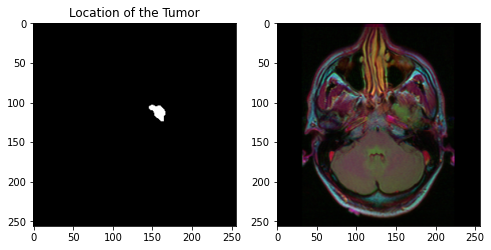

In [13]:
for i in range(len(brainscan_df)):
    if cv2.imread(brainscan_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brainscan_df.mask_path[i]));
plt.title('Location of the Tumor')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brainscan_df.image_path[i]));

In [14]:
cv2.imread(brainscan_df.mask_path[i]).max(), cv2.imread(brainscan_df.mask_path[i]).min()

(255, 0)

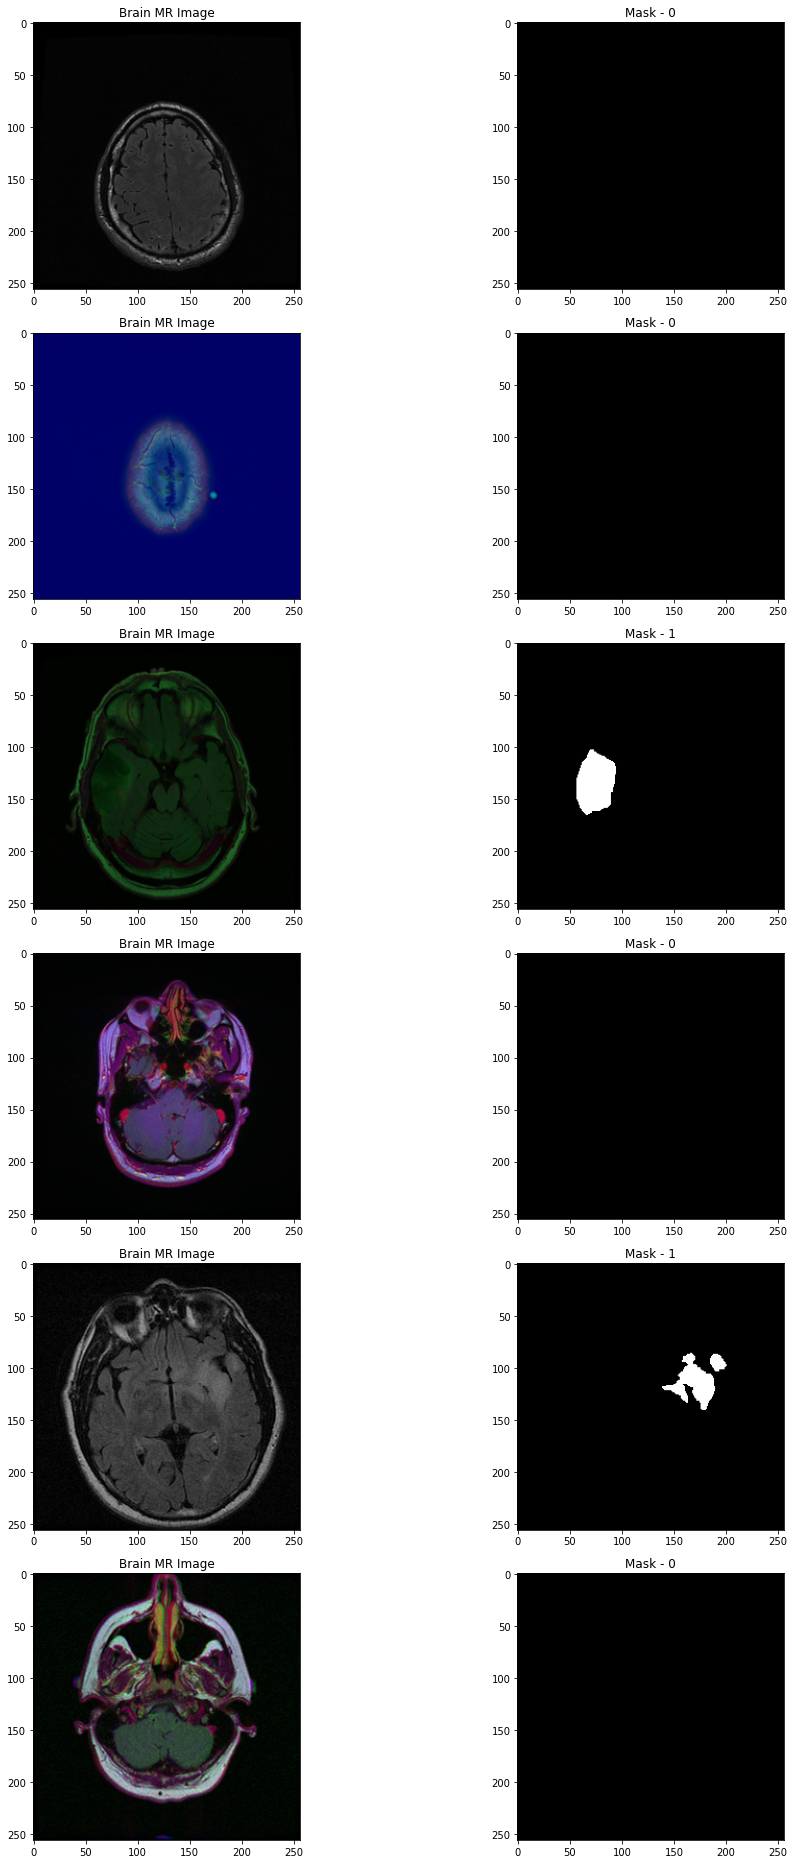

In [15]:
# Visualize the MRI and MASK images in the dataset 

fig, axs = plt.subplots(6,2, figsize=(16,26))
count = 0
for x in range(6):
  i = random.randint(0, len(brainscan_df)) # select a random index
  axs[count][0].title.set_text("Brain MR Image") # set title
  axs[count][0].imshow(cv2.imread(brainscan_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brainscan_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brainscan_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

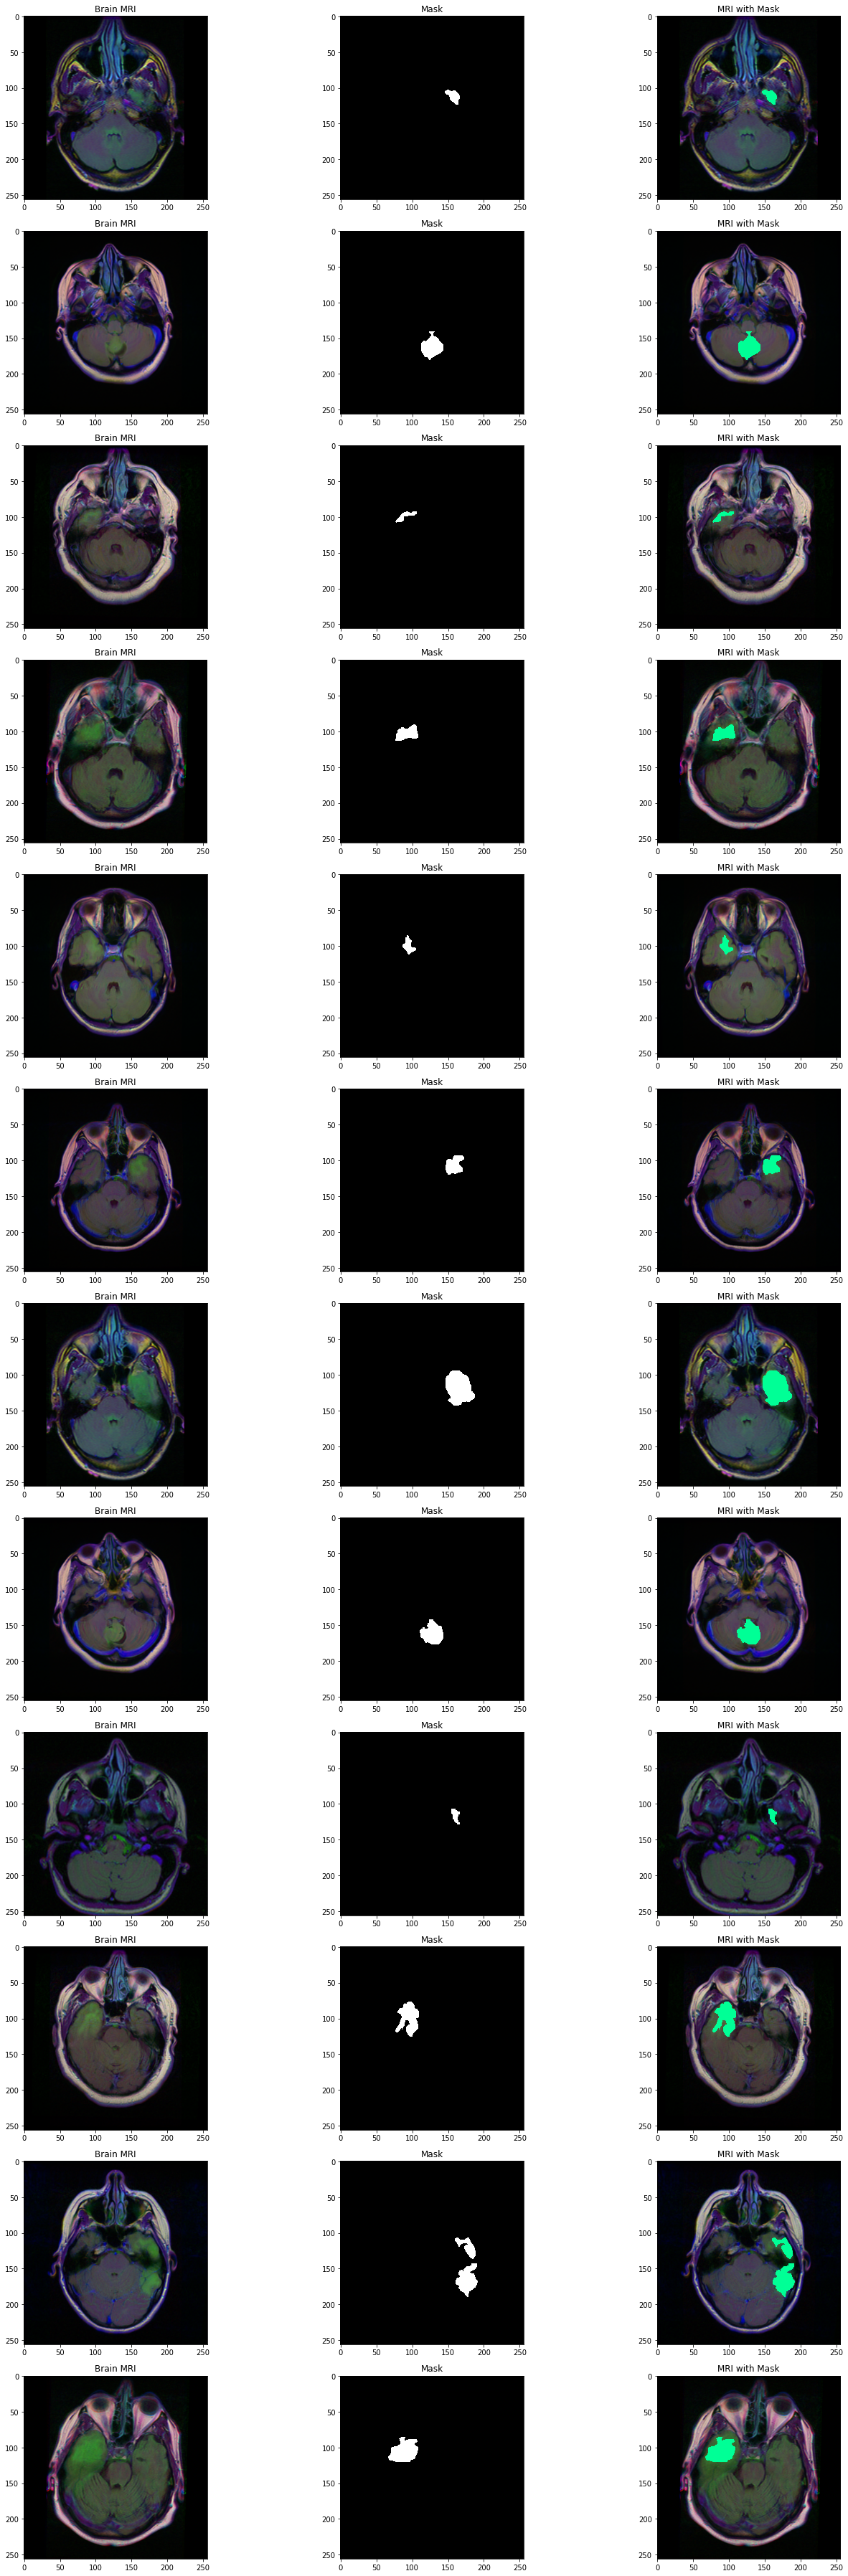

In [16]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for mask in brainscan_df['mask']:
    if (mask==1):
        img = io.imread(brainscan_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(brainscan_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (0,255,150)  # modifying the pixel color at the location of the mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break
        
fig.tight_layout()

# CREATE TESTING, TRAINING & VALIDATION SET

In [17]:
brainscan_df_train = brainscan_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brainscan_df_train['mask'] = brainscan_df_train['mask'].apply(lambda x: str(x))
brainscan_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [18]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brainscan_df_train, test_size=0.15)

In [19]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


# TRAIN A CLASSIFIER MODEL TO DETECT IF TUMOR EXISTS OR NOT

In [20]:
from tensorflow.keras.applications.resnet50 import ResNet50
clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
clf_model.summary()

2022-02-28 14:54:15.640060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 14:54:15.648069: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 14:54:15.648794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 14:54:15.650024: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [21]:
# before this i tried with trainable layer but the accuracy was less as compared
for layer in clf_model.layers:
    layers.trainable = False

In [22]:
head = clf_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [23]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

In [24]:
h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 30, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])

2022-02-28 14:54:18.286157: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-02-28 14:54:23.264304: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


187/187 [==============================] - 32s 140ms/step - loss: 0.6782 - accuracy: 0.7124 - val_loss: 1.7011 - val_accuracy: 0.6281

Epoch 00001: val_loss improved from inf to 1.70108, saving model to clf-resnet-weights.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 2/30
187/187 [==============================] - 25s 132ms/step - loss: 0.4161 - accuracy: 0.7920 - val_loss: 0.6715 - val_accuracy: 0.6281

Epoch 00002: val_loss improved from 1.70108 to 0.67150, saving model to clf-resnet-weights.hdf5
Epoch 3/30
187/187 [==============================] - 25s 132ms/step - loss: 0.3554 - accuracy: 0.8395 - val_loss: 0.6686 - val_accuracy: 0.6313

Epoch 00003: val_loss improved from 0.67150 to 0.66856, saving model to clf-resnet-weights.hdf5
Epoch 4/30
187/187 [==============================] - 25s 132ms/step - loss: 0.3050 - accuracy: 0.8746 - val_loss: 0.8228 - val_accuracy: 0.6375

Epoch 00004: val_loss did not improve from 0.66856
Epoch 5/30
187/187 [==============================] - 25s 132ms/step - loss: 0.2899 - accuracy: 0.8903 - val_loss: 0.5847 - val_accuracy: 0.7281

Epoch 00005: val_loss improved from 0.66856 to 0.58474, saving model to clf-resnet-weights.hdf5
Epoch 6/30
187/187 [==============================] - 25s 132ms/step - loss: 

In [25]:
# saving model achitecture in json file
model_json = model.to_json()
with open("clf-resnet-model.json", "w") as json_file:
    json_file.write(model_json)

# EVALUATION OF THE CLASSIFIER/CLASSIFICATION MODEL 





In [26]:
h.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

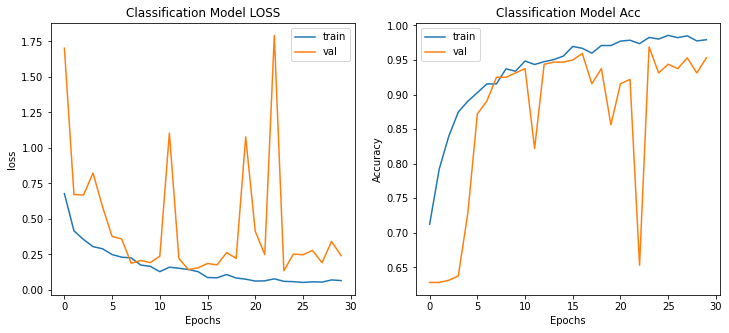

In [27]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [28]:
_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

37/37 [==============================] - 2s 56ms/step - loss: 0.2665 - accuracy: 0.9458
Test accuracy : 94.57626938819885 %


0.9457627118644067
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       398
           1       0.94      0.89      0.91       192

    accuracy                           0.95       590
   macro avg       0.94      0.93      0.94       590
weighted avg       0.95      0.95      0.95       590



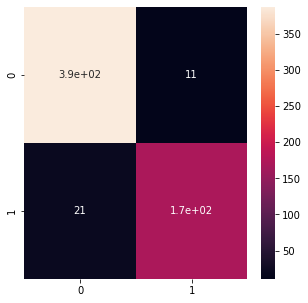

In [29]:
prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

# BUILDING A SEGMENTATION MODEL TO LOCALIZE TUMOR

In [30]:
brainscan_df_mask = brainscan_df[brainscan_df['mask'] == 1]
brainscan_df_mask.shape

(1373, 4)

In [31]:
# create testing, training and validation sets
X_train, X_val = train_test_split(brainscan_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 1167, valid size is 103 & test size is 103


In [32]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    # shuffle the indices, if shuffle is true
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = str(list_ids[i])
      
      #mask path
      mask_path = str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

In [33]:
# model creation
def resblock(X, f):
    '''
    function for creating res block
    '''
    X_copy = X  #copy of input
    
    # main path
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    # shortcut path
    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    
    # Adding the output from main path and short path together
    X = Add()([X, X_copy])
    X = Activation('relu')(X)
    
    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

In [34]:
#initiating tensor of input shape
input_shape = (256,256,3)
X_input = Input(input_shape) 

# Stage 1
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)

# stage 2
conv_2 = resblock(pool_1, 32)
pool_2 = MaxPool2D((2,2))(conv_2)

# Stage 3
conv_3 = resblock(pool_2, 64)
pool_3 = MaxPool2D((2,2))(conv_3)

# Stage 4
conv_4 = resblock(pool_3, 128)
pool_4 = MaxPool2D((2,2))(conv_4)

# Stage 5 (bottle neck)
conv_5 = resblock(pool_4, 256)

# Upsample Stage 1
up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)

# Upsample Stage 2
up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)

# Upsample Stage 3
up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)

# Upsample Stage 4
up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)

# final output
out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

seg_model = Model(X_input, out)
seg_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
____________________________________________________________________________________________

# TRAIN THE SEGMENTATION MODEL

In [35]:
# Define a custom loss function for ResUNet model

# Reference : (https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py)

from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [36]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
seg_model.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-segModel-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [37]:
h = seg_model.fit(train_data, 
                  epochs = 30, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/30
72/72 [==============================] - 13s 129ms/step - loss: 0.9040 - tversky: 0.1254 - val_loss: 0.8927 - val_tversky: 0.1404

Epoch 00001: val_loss improved from inf to 0.89274, saving model to ResUNet-segModel-weights.hdf5
Epoch 2/30
72/72 [==============================] - 8s 110ms/step - loss: 0.6481 - tversky: 0.4316 - val_loss: 0.6105 - val_tversky: 0.4796

Epoch 00002: val_loss improved from 0.89274 to 0.61046, saving model to ResUNet-segModel-weights.hdf5
Epoch 3/30
72/72 [==============================] - 8s 114ms/step - loss: 0.4206 - tversky: 0.6829 - val_loss: 0.5684 - val_tversky: 0.5261

Epoch 00003: val_loss improved from 0.61046 to 0.56842, saving model to ResUNet-segModel-weights.hdf5
Epoch 4/30
72/72 [==============================] - 9s 119ms/step - loss: 0.3567 - tversky: 0.7451 - val_loss: 0.4417 - val_tversky: 0.6627

Epoch 00004: val_loss improved from 0.56842 to 0.44169, saving model to ResUNet-segModel-weights.hdf5
Epoch 5/30
72/72 [=============

In [38]:
# saving model achitecture in json file
seg_model_json = seg_model.to_json()
with open("ResUNet-seg-model.json", "w") as json_file:
    json_file.write(seg_model_json)

# SEGMENTATION MODEL EVALUATION

In [39]:
h.history.keys()

dict_keys(['loss', 'tversky', 'val_loss', 'val_tversky', 'lr'])

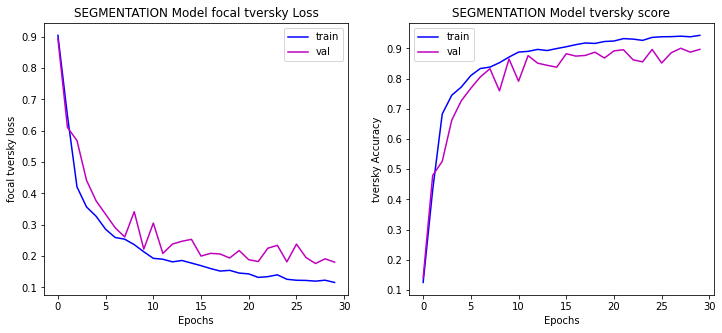

In [40]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss'], c='b');
plt.plot(h.history['val_loss'], c='m');
plt.title("SEGMENTATION Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['tversky'], c='b');
plt.plot(h.history['val_tversky'], c='m');
plt.title("SEGMENTATION Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [41]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = seg_model.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))

6/6 [==============================] - 1s 88ms/step - loss: 0.1709 - tversky: 0.9048
Segmentation tversky is 90.48%


#  ASSESSMENT OF SEGMENTATION MODEL PERFORMANCE 
## (COMBINING THE CLASSIFICATION & SEGMENTAION MODEL BUILDING PIPELINE)

In [42]:
def prediction(test, model, model_seg):
    '''
    Predcition function which takes dataframe containing ImageID as Input and perform 2 type of prediction on the image
    Initially, image is passed through the classification network which predicts whether the image has defect or not, if the model
    is 99% sure that the image has no defect, then the image is labeled as no-defect, if the model is not sure, it passes the image to the
    segmentation network, it again checks if the image has defect or not, if it has defect, then the type and location of defect is found
    '''
    # empty list to store results
    mask, image_id, has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.image_path:
        
        img = io.imread(i)
        #normalizing
        img = img *1./255.
        #reshaping
        img = cv2.resize(img, (256,256))
        # converting img into array
        img = np.array(img, dtype=np.float64)
        #reshaping the image from 256,256,3 to 1,256,256,3
        img = np.reshape(img, (1,256,256,3))
        
        #making prediction for tumor in image
        is_defect = model.predict(img)
        
        #if tumour is not present we append the details of the image to the list
        if np.argmax(is_defect)==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
            continue
        
        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        # standardize the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img
        
        #make mask prediction
        predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is no tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
          
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

In [43]:
# making prediction
df_pred = prediction(test, model, seg_model)
df_pred

image_path  \
0    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
..                                                 ...   
585  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
586  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
587  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
588  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
589  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                        predicted_mask  has_mask  
0                                           No mask :)         0  
1                                           No mask :)         0  
2                                           No mask :)         0  
3                                           No mask :)         0  
4                                           No mask :)         0  
..                                                 ...       ...  
585  [[[[6.503594e-07], [4.5797935e-07], [1.0758491...         1  
586                                         No mask :)         0  
587  [[[[1.0219222e-06], [1.0406477e-06], [4.728737...         1  
588                                         No mask :)         0  
589                                         No mask :)         0  

[590 rows x 3 columns]

In [44]:
# merging original and prediction df
df_pred = test.merge(df_pred, on='image_path')
df_pred.head(10)

image_path  \
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
5  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
6  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
7  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
8  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
9  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                           mask_path mask  \
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
5  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    1   
6  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
7  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
8  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
9  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   

                                      predicted_mask  has_mask  
0                                         No mask :)         0  
1                                         No mask :)         0  
2                                         No mask :)         0  
3                                         No mask :)         0  
4                                         No mask :)         0  
5  [[[[1.0188093e-06], [1.5062677e-06], [6.070075...         1  
6                                         No mask :)         0  
7                                         No mask :)         0  
8                                         No mask :)         0  
9                                         No mask :)         0

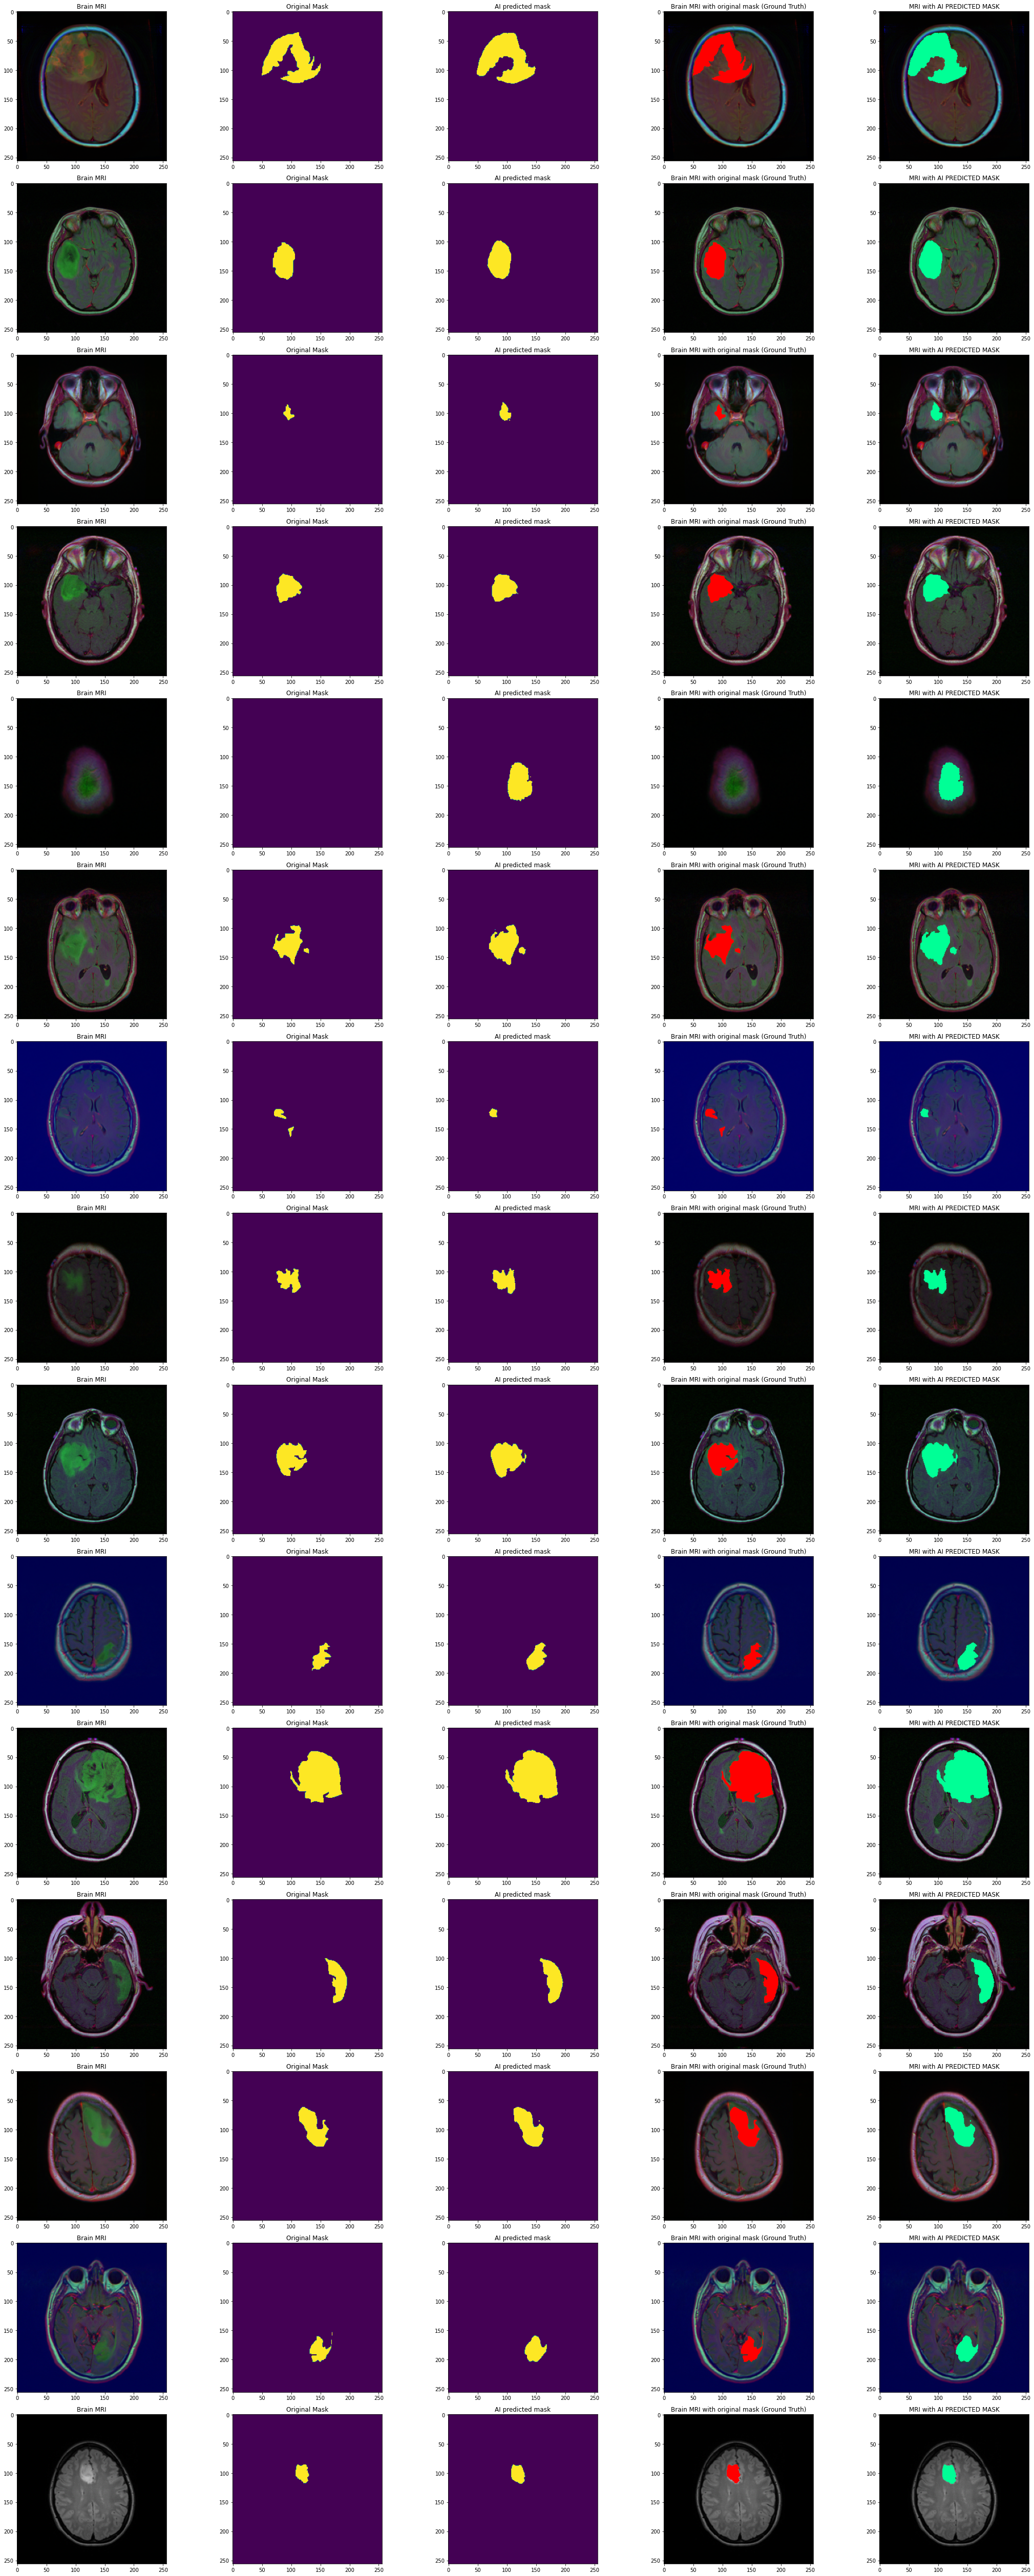

In [45]:
#visualizing prediction
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('AI predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with AI PREDICTED MASK')
        
        count +=1
    if (count==15):
        break

fig.tight_layout()        